# Multi-Layer Perceptron Regression

In [1]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('/home/jshe/prop-pred/src/data')
from data_utils import *

import torch
from models import MLPRegressor, MLPClassifier, RMLPRegressor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

## Data

In [2]:
datadir = '../../data/regress_immuno'
data = to_namedtuple(to_tensor(load_data(datadir), device))

In [3]:
train_X = torch.concat((
    #data.train.embeddings, 
    data.train.fingerprints, 
), axis=1)
validation_X = torch.concat((
    #data.validation.embeddings, 
    data.validation.fingerprints, 
), axis=1)
test_X = torch.concat((
    #data.test.embeddings, 
    data.test.fingerprints, 
), axis=1)

In [4]:
train_Y = torch.concat((
    data.train.y, 
    #data.train.y_rdkit, 
), axis=1)[:, 0].unsqueeze(1)
validation_Y = torch.concat((
    data.validation.y, 
    #data.validation.y_rdkit
), axis=1)[:, 0].unsqueeze(1)
test_Y = torch.concat((
    data.test.y, 
    #data.test.y_rdkit, 
), axis=1)[:, 0].unsqueeze(1)

## MLP Model

## Train

  3%|█▎                                       | 32/1024 [00:04<02:34,  6.41it/s]


Val.: 0.1181
Test: 0.0022
[0.00216827]


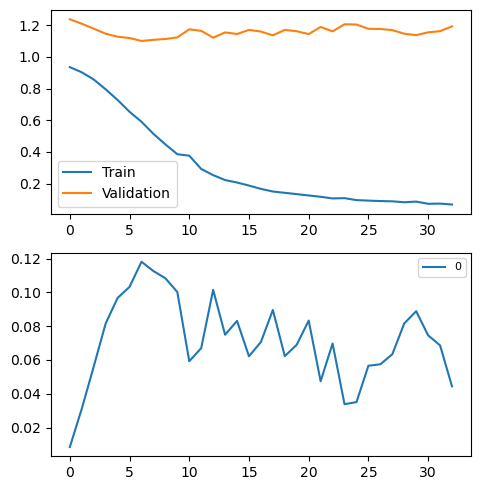

In [12]:
mlp = RMLPRegressor(
    in_features=train_X.shape[1], out_features=train_Y.shape[1], 
    depth=2, width=256, dropout=0.4
).to(device)

validation_score = mlp.fit(
    train_X, train_Y, 
    validation_X, validation_Y, 
    lr=0.0001, epochs=1024, batch_size=32, patience=0.0016, 
    early_stopping=True, plot=True, progress_bar=True
)
test_score = mlp.score(test_X, test_Y)

print(f'Val.: {validation_score:.4f}')
print(f'Test: {test_score:.4f}')
print(mlp.score(test_X, test_Y, multioutput=None))

## Visualization

In [16]:
x, y_true = train_X, train_Y

In [17]:
y_pred = mlp(x).detach()

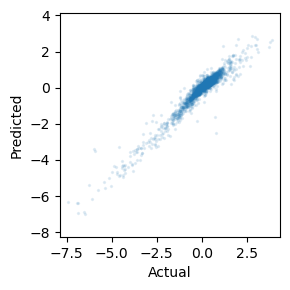

In [18]:
n_rows = n_cols = int((y_pred.shape[1]) ** 0.5)
if (n_rows * n_cols) < y_pred.shape[1]: n_cols += 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_rows * 3, n_cols * 3))
if y_pred.shape[1] == 1: axs = [axs]

for i in range(y_pred.shape[1]):

    ax = axs[i]

    ax.scatter(y_true[:, i].cpu(), y_pred[:, i].cpu(), s=2, alpha=0.1)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    # ax.set_title(property_label)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()